In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools
import os
warnings.filterwarnings('ignore')

import plotly
import plotly.graph_objs as go
import plotly.express as px
from bokeh.palettes import Category20, Viridis3, Set1
from bokeh.plotting import figure, output_file, show, save, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper, OpenURL, TapTool

import hdbscan
import umap
import seaborn as sns
import pandas as pd
from DataManager import DataManager
from utils import get_umap_projection, get_hdbscan_clustering

palette1 = Category20
palette2 = Viridis3

output_notebook()

Loading BokehJS ...

In [2]:
dm = DataManager()
data_ftr_vals = dm.data.values[:,3:]
control_samples = dm.get_control_samples()
interacting_samples = dm.get_top_interactions()
original_seed = 4285866

In [3]:
dmso_indexes = []
for row in dm.drug_df.itertuples():
    #"dimethyl" in row.Name or "DMSO" in row.SecName or 
    if "ctr" in row.GeneID and "DMSO" in row.Content:
        dmso_indexes.append(row.Index)

control_data = dm.data[(dm.data["drug"].isin(dmso_indexes))]

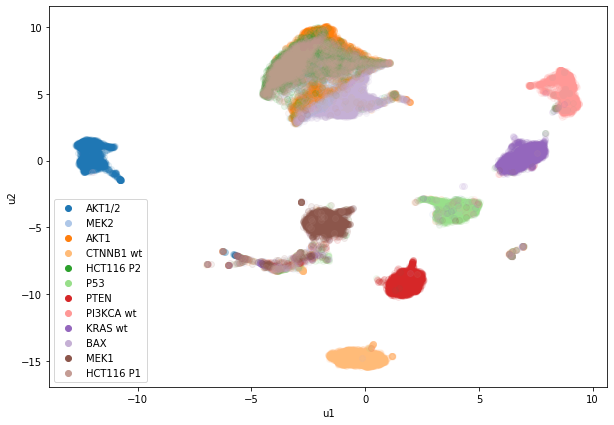

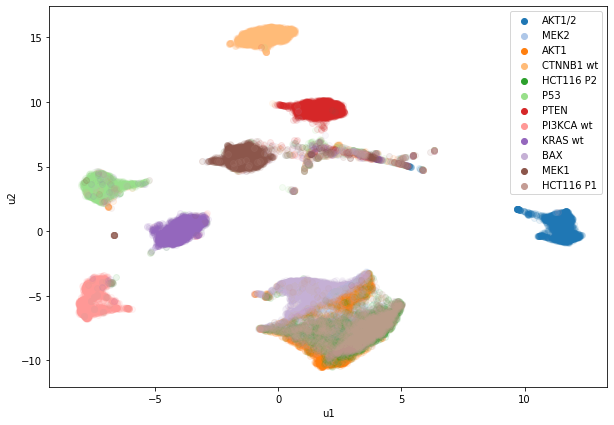

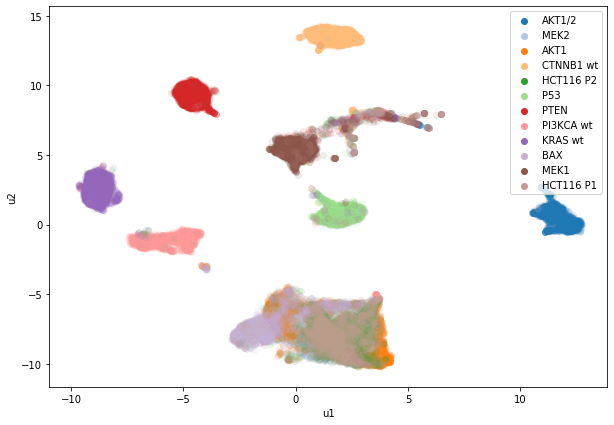

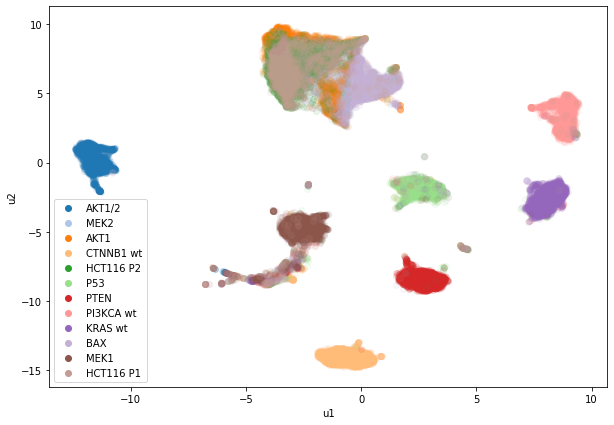

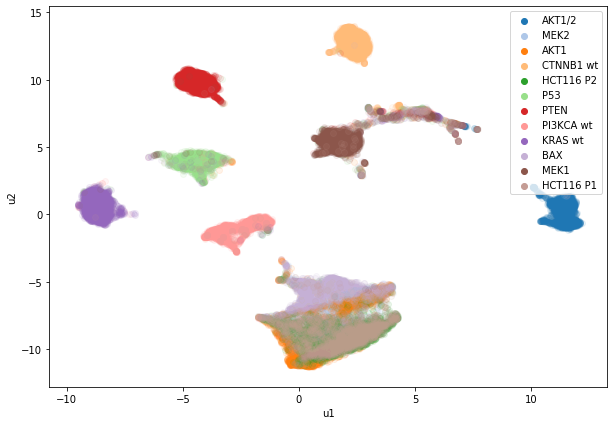

In [4]:
seeds = np.random.randint(0, 10000, 5)
for seed in seeds:
    reducer = umap.UMAP(n_components=2, random_state=seed)
    umap_embedding = reducer.fit_transform(data_ftr_vals)
    
    fig, ax = plt.subplots(figsize=(10,7))

    colors = itertools.cycle(palette1[12])    
    for cell_line, color in zip(range(12), colors):
        name = dm.cell_line_df["mutation"].iloc[cell_line]
        cl_indexes = dm.data.index[dm.data["cell_line"]==cell_line].tolist()
        ax.scatter(umap_embedding[cl_indexes,0], umap_embedding[cl_indexes,1], c=color, alpha=0.09, label=name)

    ax.set_xlabel("u1")
    ax.set_ylabel("u2")
    leg = ax.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    plt.show()
    plt.close(fig)

In [5]:
seeds[3]

2023

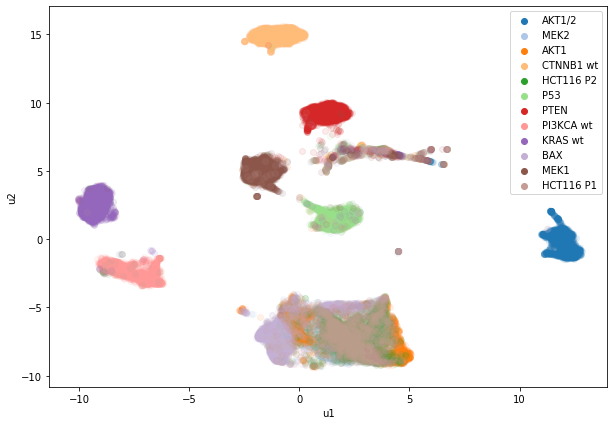

In [4]:
seed = 9135
reducer = umap.UMAP(n_components=2, random_state=seed)
umap_embedding = reducer.fit_transform(data_ftr_vals)

fig, ax = plt.subplots(figsize=(10,7))

colors = itertools.cycle(palette1[12])    
for cell_line, color in zip(range(12), colors):
    name = dm.cell_line_df["mutation"].iloc[cell_line]
    cl_indexes = dm.data.index[dm.data["cell_line"]==cell_line].tolist()
    ax.scatter(umap_embedding[cl_indexes,0], umap_embedding[cl_indexes,1], c=color, alpha=0.09, label=name)

ax.set_xlabel("u1")
ax.set_ylabel("u2")
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.show()
plt.close(fig)

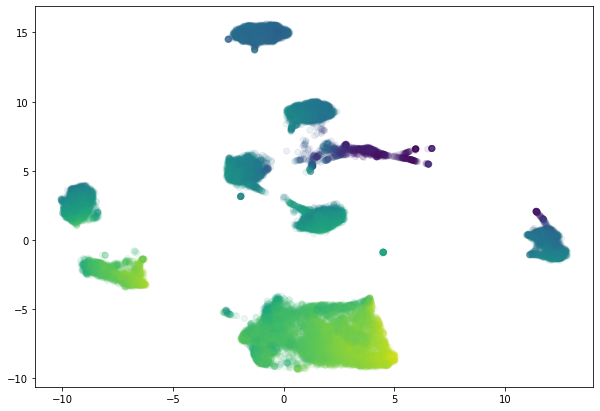

In [9]:
clr = dm.data["n"].values
clr -= np.min(clr)
clr /= np.max(clr)

fig, ax = plt.subplots(figsize=(10,7))
s = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=clr, alpha=0.09)


In [7]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=80,
                                cluster_selection_epsilon=0.32, min_samples=30).fit(umap_embedding)
hdbscan_cluster_labels = clusterer.labels_

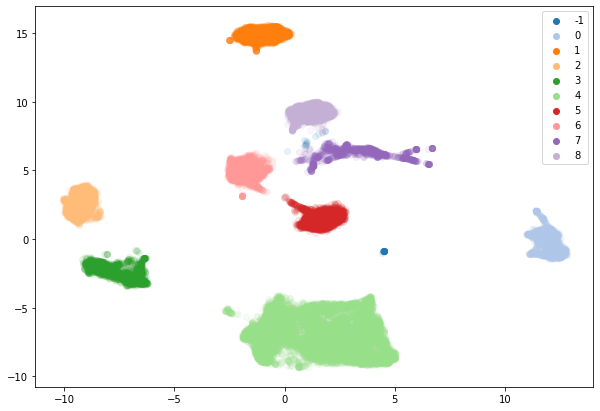

In [8]:
fig, ax = plt.subplots(figsize=(10,7))
colors = itertools.cycle(palette1[12])    
for label, color in zip(np.unique(hdbscan_cluster_labels), colors):
    #name = dm.cell_line_df["mutation"].iloc[cell_line]
    name = str(label)
    label_indexes = np.where(hdbscan_cluster_labels==label)[0]
    ax.scatter(umap_embedding[label_indexes,0], umap_embedding[label_indexes,1], c=color, alpha=0.09, label=name)
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.show()

In [9]:
def find_cluster_transitions(drug):
    control_samples_labels = []
    treated_samples_labels = []
    control_proportions = np.zeros((12,len(np.unique(hdbscan_cluster_labels))-1))
    treated_proportions = np.zeros((12,len(np.unique(hdbscan_cluster_labels))-1))
    for cl in range(12):
        cl_control_samples = control_data[control_data["cell_line"]==cl].index
        for idx in cl_control_samples:
            label = hdbscan_cluster_labels[idx]
            control_samples_labels.append((idx, label))
            if label >= 0:
                control_proportions[cl, label] += 1
        treated_samples = dm.data[(dm.data["drug"]==drug)&(dm.data["cell_line"]==cl)]
        treated_samples = treated_samples[~treated_samples.index.isin(cl_control_samples)].index
        for idx in treated_samples:
            label = hdbscan_cluster_labels[idx]
            treated_samples_labels.append((idx, label))
            if label >= 0:
                treated_proportions[cl, label] += 1
    control_proportions /= control_proportions.sum(axis=1)[:,None]
    treated_proportions /= treated_proportions.sum(axis=1)[:,None]
    return control_samples_labels, treated_samples_labels, control_proportions,treated_proportions

In [10]:
control_samples_labels, treated_samples_labels, control_proportions,treated_proportions = find_cluster_transitions(23)

In [11]:
control_proportions

array([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 0.95, 0.05, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.95, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ]])

In [12]:
treated_proportions

array([[1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0. , 0. , 0.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0.5, 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. ]])

In [13]:
np.unique(hdbscan_cluster_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [14]:
transitions_to_int = []
for drg in range(1372):
    control_samples_labels, treated_samples_labels, control_proportions,treated_proportions = find_cluster_transitions(drg)
    transitions = treated_proportions-control_proportions
    if any(transitions[:,7]>0):
        transitions_to_int.append(drg)
        print(drg)

21
23
26
35
41
60
85
112
125
126
136
150
215
241
265
273
303
311
335
336
337
339
385
400
405
429
430
467
482
494
501
509
515
530
537
581
584
600
633
645
663
728
734
746
772
774
824
837
858
869
897
908
909
921
941
974
978
979
994
1001
1033
1044
1047
1050
1052
1063
1064
1066
1070
1074
1098
1114
1123
1150
1152
1156
1179
1195
1226
1231
1240
1241
1243
1259
1261
1264
1290
1306
1316
1335
1336
